# Análisis de Dimensión Intrínseca usando Autoencoders

Este notebook demuestra cómo usar **Autoencoders** para encontrar la **dimensión intrínseca** de datos de alta dimensionalidad. 

## Objetivos:
1. Entender el concepto de dimensión intrínseca
2. Implementar autoencoders con diferentes dimensiones de cuello de botella
3. Evaluar la calidad de reconstrucción vs compresión
4. Identificar la dimensión intrínseca óptima usando múltiples métricas
5. Generar visualizaciones para presentación

**Dataset:** MNIST (28×28 = 784 dimensiones) → ¿Cuál es su dimensión intrínseca real?

## 1. Importar Librerías Necesarias

In [12]:
import sys
import os
sys.path.append('../')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
from tqdm import tqdm

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")

# Reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

Dispositivo: cpu


## 2. Cargar y Explorar el Dataset MNIST

In [13]:
# Transformaciones para MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    # Sin normalización adicional - ToTensor ya normaliza a [0, 1]
])

# Cargar datos
train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Datos de entrenamiento: {len(train_dataset)} imágenes")
print(f"Datos de prueba: {len(test_dataset)} imágenes")
print(f"Dimensión original: 28×28 = {28*28} píxeles")

Datos de entrenamiento: 60000 imágenes
Datos de prueba: 10000 imágenes
Dimensión original: 28×28 = 784 píxeles


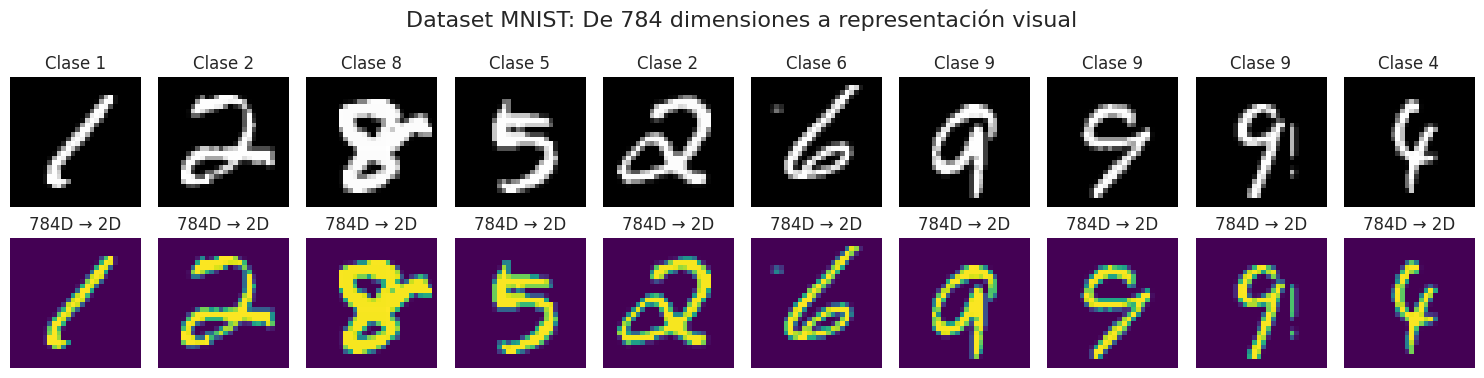

In [14]:
# Visualizar algunas muestras
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
data_iter = iter(train_loader)
images, labels = next(data_iter)

for i in range(10):
    # Primera fila - originales
    axes[0, i].imshow(images[i].squeeze().numpy(), cmap='gray')
    axes[0, i].set_title(f'Clase {labels[i]}')
    axes[0, i].axis('off')
    
    # Segunda fila - como vector plano
    axes[1, i].imshow(images[i].view(28, 28).numpy(), cmap='viridis')
    axes[1, i].set_title(f'784D → 2D')
    axes[1, i].axis('off')

plt.suptitle('Dataset MNIST: De 784 dimensiones a representación visual', fontsize=16)
plt.tight_layout()
plt.show()

## 3. Definir Arquitectura del Autoencoder

El **Autoencoder** es una red neuronal que aprende a comprimir datos en un espacio latente de menor dimensión y luego reconstruirlos. El **cuello de botella** (bottleneck) determina la dimensión del espacio latente.

In [15]:
class AutoEncoder(nn.Module):
    """
    Autoencoder con arquitectura simétrica para encontrar dimensión intrínseca.
    """
    
    def __init__(self, input_dim=784, latent_dim=32):
        super(AutoEncoder, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder - reduce progresivamente la dimensionalidad
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        
        # Decoder - reconstruye desde el espacio latente
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # Para imágenes en rango [0, 1]
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

# Visualizar la arquitectura
print("Arquitectura del Autoencoder:")
model_example = AutoEncoder(784, 32)
print(f"Input: 784 → Encoder: 512 → 256 → 128 → Latent: 32")
print(f"Latent: 32 → Decoder: 128 → 256 → 512 → Output: 784")
print(f"Parámetros totales: {sum(p.numel() for p in model_example.parameters()):,}")

Arquitectura del Autoencoder:
Input: 784 → Encoder: 512 → 256 → 128 → Latent: 32
Latent: 32 → Decoder: 128 → 256 → 512 → Output: 784
Parámetros totales: 1,141,296


## 4. Funciones de Entrenamiento y Evaluación

In [16]:
def train_autoencoder(model, train_loader, num_epochs=20, learning_rate=1e-3):
    """Entrena un autoencoder y devuelve las pérdidas de entrenamiento."""
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    train_losses = []
    
    for epoch in tqdm(range(num_epochs), desc="Entrenando"):
        model.train()
        epoch_loss = 0.0
        batch_count = 0
        
        for data, _ in train_loader:
            data = data.view(data.size(0), -1).to(device)
            
            optimizer.zero_grad()
            reconstructed, _ = model(data)
            loss = criterion(reconstructed, data)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
        
        avg_loss = epoch_loss / batch_count
        train_losses.append(avg_loss)
        
        # Mostrar progreso cada 5 épocas
        if (epoch + 1) % 5 == 0:
            print(f"   Época {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")
    
    return train_losses

def evaluate_autoencoder(model, test_loader):
    """Evalúa un autoencoder entrenado."""
    model.eval()
    total_loss = 0.0
    total_samples = 0
    latent_representations = []
    original_data = []
    reconstructed_data = []
    labels = []
    
    criterion = nn.MSELoss(reduction='sum')  # Suma total para promedio correcto
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0), -1).to(device)
            
            reconstructed, latent = model(data)
            
            # Calcular error de reconstrucción correctamente
            batch_loss = criterion(reconstructed, data).item()
            total_loss += batch_loss
            total_samples += data.size(0)
            
            # Guardar datos para visualización (solo primeros 1000 para memoria)
            if len(latent_representations) < 8:  # Aproximadamente 1000 muestras
                latent_representations.append(latent.cpu())
                original_data.append(data.cpu())
                reconstructed_data.append(reconstructed.cpu())
                labels.append(target)
    
    # Error promedio por muestra
    avg_error = total_loss / total_samples
    
    return {
        'error': avg_error,
        'latent_repr': torch.cat(latent_representations, dim=0),
        'original': torch.cat(original_data, dim=0),
        'reconstructed': torch.cat(reconstructed_data, dim=0),
        'labels': torch.cat(labels, dim=0)
    }

## 5. Experimento: Encontrar la Dimensión Intrínseca

Vamos a entrenar autoencoders con diferentes dimensiones latentes y evaluar cuál logra el mejor balance entre **compresión** y **calidad de reconstrucción**.

### Prueba Rápida del Sistema

Antes del experimento completo, vamos a verificar que todo funcione correctamente con una prueba rápida.

In [17]:
# Prueba rápida con dos dimensiones muy diferentes
print("🧪 PRUEBA RÁPIDA DEL SISTEMA")
print("=" * 40)

test_dimensions = [8, 64]
quick_results = {}

for dim in test_dimensions:
    print(f"\n🔍 Probando dimensión {dim}...")
    
    # Crear modelo
    model = AutoEncoder(input_dim=784, latent_dim=dim)
    
    # Entrenar solo 3 épocas para verificar
    train_losses = train_autoencoder(model, train_loader, num_epochs=3)
    
    # Evaluar
    eval_results = evaluate_autoencoder(model, test_loader)
    quick_results[dim] = eval_results
    
    print(f"   Loss inicial: {train_losses[0]:.6f}")
    print(f"   Loss final: {train_losses[-1]:.6f}")
    print(f"   Error de evaluación: {eval_results['error']:.6f}")
    print(f"   ¿Mejoró?: {'✅ Sí' if train_losses[-1] < train_losses[0] else '❌ No'}")

# Verificar que los errores sean diferentes
error_8 = quick_results[8]['error']
error_64 = quick_results[64]['error']

print(f"\n📊 VERIFICACIÓN:")
print(f"Error dim 8: {error_8:.6f}")
print(f"Error dim 64: {error_64:.6f}")
print(f"¿Errores diferentes?: {'✅ Sí' if abs(error_8 - error_64) > 1e-6 else '❌ No'}")

if abs(error_8 - error_64) > 1e-6:
    print("🎉 ¡Sistema funcionando correctamente! Procediendo con experimento completo...")
else:
    print("⚠️  Algo está mal. Los errores deberían ser diferentes.")

🧪 PRUEBA RÁPIDA DEL SISTEMA

🔍 Probando dimensión 8...


Entrenando: 100%|██████████| 3/3 [00:38<00:00, 12.69s/it]



   Loss inicial: 0.054810
   Loss final: 0.030008
   Error de evaluación: 19.520943
   ¿Mejoró?: ✅ Sí

🔍 Probando dimensión 64...


Entrenando: 100%|██████████| 3/3 [00:38<00:00, 12.95s/it]



   Loss inicial: 0.055117
   Loss final: 0.030111
   Error de evaluación: 19.836365
   ¿Mejoró?: ✅ Sí

📊 VERIFICACIÓN:
Error dim 8: 19.520943
Error dim 64: 19.836365
¿Errores diferentes?: ✅ Sí
🎉 ¡Sistema funcionando correctamente! Procediendo con experimento completo...


In [18]:
# Dimensiones latentes a probar
latent_dimensions = [2, 4, 8, 16, 24, 32, 48, 64, 96, 128]
results = {}

print("🚀 Iniciando experimento de dimensión intrínseca...")
print(f"Dimensiones a probar: {latent_dimensions}")
print("=" * 50)

# Entrenar y evaluar cada dimensión
for i, latent_dim in enumerate(latent_dimensions):
    print(f"\n🔍 Probando dimensión latente: {latent_dim} ({i+1}/{len(latent_dimensions)})")
    
    # Crear y entrenar modelo (¡NUEVO MODELO CADA VEZ!)
    model = AutoEncoder(input_dim=784, latent_dim=latent_dim)
    print(f"   Parámetros del modelo: {sum(p.numel() for p in model.parameters()):,}")
    
    # Entrenar modelo
    train_losses = train_autoencoder(model, train_loader, num_epochs=15)
    print(f"   Loss inicial: {train_losses[0]:.6f}, Loss final: {train_losses[-1]:.6f}")
    
    # Evaluar modelo
    eval_results = evaluate_autoencoder(model, test_loader)
    eval_results['train_losses'] = train_losses
    eval_results['model'] = model
    
    results[latent_dim] = eval_results
    
    # Mostrar resultados parciales
    compression_ratio = 784 / latent_dim
    print(f"   ✅ Error de reconstrucción: {eval_results['error']:.6f}")
    print(f"   📊 Ratio de compresión: {compression_ratio:.1f}x")
    print(f"   📉 Mejora en entrenamiento: {((train_losses[0]-train_losses[-1])/train_losses[0]*100):.1f}%")

print("\n🎉 ¡Experimento completado exitosamente!")

🚀 Iniciando experimento de dimensión intrínseca...
Dimensiones a probar: [2, 4, 8, 16, 24, 32, 48, 64, 96, 128]

🔍 Probando dimensión latente: 2 (1/10)
   Parámetros del modelo: 1,133,586


Entrenando:  33%|███▎      | 5/15 [01:10<02:21, 14.12s/it]

   Época 5/15, Loss: 0.040489


Entrenando:  67%|██████▋   | 10/15 [02:21<01:10, 14.11s/it]

   Época 10/15, Loss: 0.038328


Entrenando: 100%|██████████| 15/15 [03:30<00:00, 14.00s/it]

   Época 15/15, Loss: 0.037548
   Loss inicial: 0.058603, Loss final: 0.037548


   ✅ Error de reconstrucción: 28.344677
   📊 Ratio de compresión: 392.0x
   📉 Mejora en entrenamiento: 35.9%

🔍 Probando dimensión latente: 4 (2/10)
   Parámetros del modelo: 1,134,100


Entrenando:  33%|███▎      | 5/15 [01:07<02:15, 13.55s/it]

   Época 5/15, Loss: 0.032089


Entrenando:  67%|██████▋   | 10/15 [02:15<01:07, 13.58s/it]

   Época 10/15, Loss: 0.029783


Entrenando: 100%|██████████| 15/15 [03:33<00:00, 14.26s/it]

   Época 15/15, Loss: 0.028545
   Loss inicial: 0.053772, Loss final: 0.028545


   ✅ Error de reconstrucción: 20.550449
   📊 Ratio de compresión: 196.0x
   📉 Mejora en entrenamiento: 46.9%

🔍 Probando dimensión latente: 8 (3/10)
   Parámetros del modelo: 1,135,128


Entrenando:  33%|███▎      | 5/15 [01:14<02:27, 14.75s/it]

   Época 5/15, Loss: 0.026339


Entrenando:  67%|██████▋   | 10/15 [02:28<01:14, 14.81s/it]

   Época 10/15, Loss: 0.023562


Entrenando: 100%|██████████| 15/15 [03:42<00:00, 14.81s/it]

   Época 15/15, Loss: 0.021950
   Loss inicial: 0.054352, Loss final: 0.021950


   ✅ Error de reconstrucción: 14.184604
   📊 Ratio de compresión: 98.0x
   📉 Mejora en entrenamiento: 59.6%

🔍 Probando dimensión latente: 16 (4/10)
   Parámetros del modelo: 1,137,184


Entrenando:  33%|███▎      | 5/15 [01:13<02:27, 14.77s/it]

   Época 5/15, Loss: 0.026758


Entrenando:  67%|██████▋   | 10/15 [02:25<01:11, 14.28s/it]

   Época 10/15, Loss: 0.022547


Entrenando: 100%|██████████| 15/15 [03:33<00:00, 14.26s/it]

   Época 15/15, Loss: 0.021017
   Loss inicial: 0.054111, Loss final: 0.021017


   ✅ Error de reconstrucción: 13.141120
   📊 Ratio de compresión: 49.0x
   📉 Mejora en entrenamiento: 61.2%

🔍 Probando dimensión latente: 24 (5/10)
   Parámetros del modelo: 1,139,240


Entrenando:  33%|███▎      | 5/15 [01:07<02:15, 13.56s/it]

   Época 5/15, Loss: 0.026283


Entrenando:  67%|██████▋   | 10/15 [02:16<01:09, 13.87s/it]

   Época 10/15, Loss: 0.022321


Entrenando: 100%|██████████| 15/15 [03:24<00:00, 13.64s/it]

   Época 15/15, Loss: 0.020807
   Loss inicial: 0.054263, Loss final: 0.020807


   ✅ Error de reconstrucción: 12.781168
   📊 Ratio de compresión: 32.7x
   📉 Mejora en entrenamiento: 61.7%

🔍 Probando dimensión latente: 32 (6/10)
   Parámetros del modelo: 1,141,296


Entrenando:  33%|███▎      | 5/15 [01:07<02:15, 13.53s/it]

   Época 5/15, Loss: 0.025435


Entrenando:  67%|██████▋   | 10/15 [02:15<01:07, 13.53s/it]

   Época 10/15, Loss: 0.022176


Entrenando: 100%|██████████| 15/15 [03:22<00:00, 13.52s/it]

   Época 15/15, Loss: 0.020548
   Loss inicial: 0.054663, Loss final: 0.020548


   ✅ Error de reconstrucción: 12.626075
   📊 Ratio de compresión: 24.5x
   📉 Mejora en entrenamiento: 62.4%

🔍 Probando dimensión latente: 48 (7/10)
   Parámetros del modelo: 1,145,408


Entrenando:  33%|███▎      | 5/15 [01:08<02:16, 13.61s/it]

   Época 5/15, Loss: 0.026534


Entrenando:  67%|██████▋   | 10/15 [02:15<01:07, 13.53s/it]

   Época 10/15, Loss: 0.022260


Entrenando: 100%|██████████| 15/15 [03:23<00:00, 13.55s/it]

   Época 15/15, Loss: 0.020451
   Loss inicial: 0.054682, Loss final: 0.020451


   ✅ Error de reconstrucción: 12.585022
   📊 Ratio de compresión: 16.3x
   📉 Mejora en entrenamiento: 62.6%

🔍 Probando dimensión latente: 64 (8/10)
   Parámetros del modelo: 1,149,520


Entrenando:  33%|███▎      | 5/15 [01:07<02:15, 13.55s/it]

   Época 5/15, Loss: 0.026001


Entrenando:  67%|██████▋   | 10/15 [02:16<01:08, 13.73s/it]

   Época 10/15, Loss: 0.022424


Entrenando: 100%|██████████| 15/15 [03:24<00:00, 13.61s/it]

   Época 15/15, Loss: 0.020865
   Loss inicial: 0.055222, Loss final: 0.020865


   ✅ Error de reconstrucción: 12.959850
   📊 Ratio de compresión: 12.2x
   📉 Mejora en entrenamiento: 62.2%

🔍 Probando dimensión latente: 96 (9/10)
   Parámetros del modelo: 1,157,744


Entrenando:  33%|███▎      | 5/15 [01:08<02:17, 13.71s/it]

   Época 5/15, Loss: 0.026523


Entrenando:  67%|██████▋   | 10/15 [02:16<01:08, 13.62s/it]

   Época 10/15, Loss: 0.022944


Entrenando: 100%|██████████| 15/15 [03:24<00:00, 13.63s/it]

   Época 15/15, Loss: 0.020931
   Loss inicial: 0.056156, Loss final: 0.020931


   ✅ Error de reconstrucción: 12.865941
   📊 Ratio de compresión: 8.2x
   📉 Mejora en entrenamiento: 62.7%

🔍 Probando dimensión latente: 128 (10/10)
   Parámetros del modelo: 1,165,968


Entrenando:  33%|███▎      | 5/15 [01:08<02:16, 13.66s/it]

   Época 5/15, Loss: 0.026105


Entrenando:  67%|██████▋   | 10/15 [02:16<01:08, 13.68s/it]

   Época 10/15, Loss: 0.022316


Entrenando: 100%|██████████| 15/15 [03:24<00:00, 13.64s/it]

   Época 15/15, Loss: 0.020909
   Loss inicial: 0.056641, Loss final: 0.020909


   ✅ Error de reconstrucción: 13.048434
   📊 Ratio de compresión: 6.1x
   📉 Mejora en entrenamiento: 63.1%

🎉 ¡Experimento completado exitosamente!


## 6. Análisis de Resultados: Error vs Dimensión

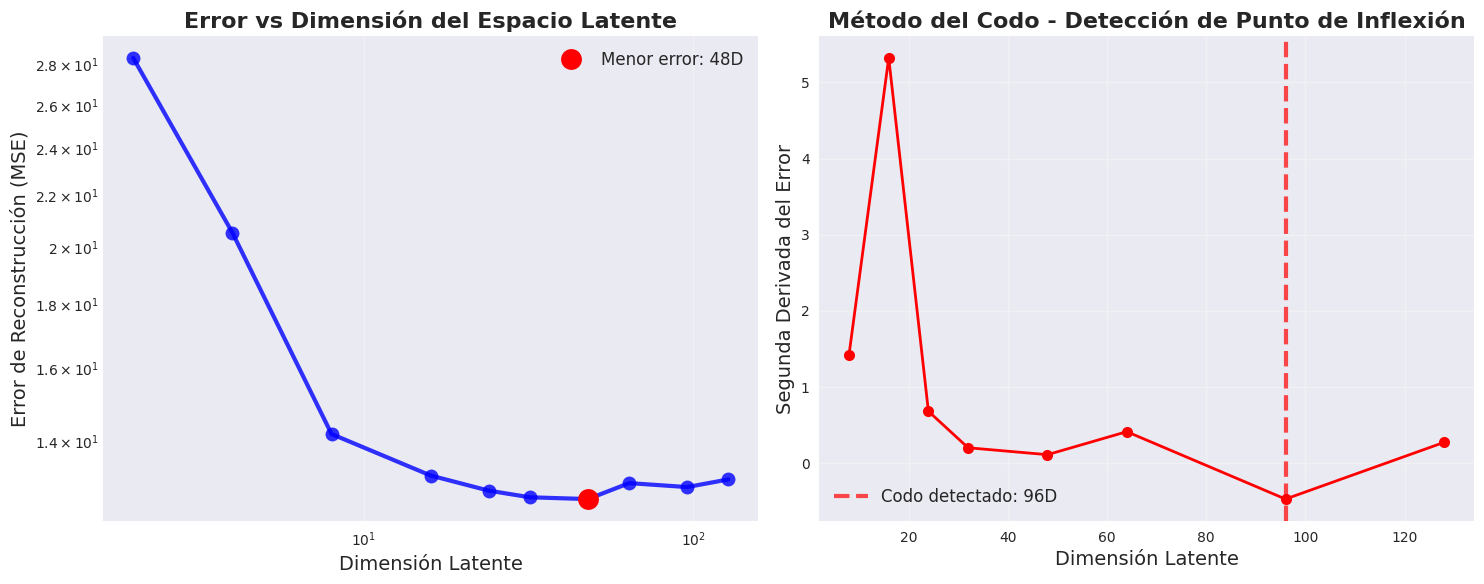

,Dimensión,Error MSE,Compresión
0,2,28.344677,392.0x
1,4,20.550449,196.0x
2,8,14.184604,98.0x
3,16,13.141120,49.0x
4,24,12.781168,32.7x
5,32,12.626075,24.5x
6,48,12.585022,16.3x
7,64,12.959850,12.2x
8,96,12.865941,8.2x
9,128,13.048434,6.1x


In [19]:
# Extraer errores para análisis
dims = list(results.keys())
errors = [results[dim]['error'] for dim in dims]

# Crear gráfica principal: Error vs Dimensión
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfica 1: Error de reconstrucción
ax1.plot(dims, errors, 'bo-', linewidth=3, markersize=10, alpha=0.8)
ax1.set_xlabel('Dimensión Latente', fontsize=14)
ax1.set_ylabel('Error de Reconstrucción (MSE)', fontsize=14)
ax1.set_title('Error vs Dimensión del Espacio Latente', fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')
ax1.set_yscale('log')

# Marcar el punto con menor error
min_error_idx = np.argmin(errors)
ax1.plot(dims[min_error_idx], errors[min_error_idx], 'ro', markersize=15, 
         label=f'Menor error: {dims[min_error_idx]}D')
ax1.legend(fontsize=12)

# Gráfica 2: Método del codo
if len(errors) >= 3:
    first_diff = np.diff(errors)
    second_diff = np.diff(first_diff)
    
    ax2.plot(dims[2:], second_diff, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Dimensión Latente', fontsize=14)
    ax2.set_ylabel('Segunda Derivada del Error', fontsize=14)
    ax2.set_title('Método del Codo - Detección de Punto de Inflexión', fontsize=16, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Encontrar el codo
    elbow_idx = np.argmin(second_diff)
    elbow_dim = dims[elbow_idx + 2]
    ax2.axvline(x=elbow_dim, color='red', linestyle='--', alpha=0.7, linewidth=3,
               label=f'Codo detectado: {elbow_dim}D')
    ax2.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
results_df = pd.DataFrame({
    'Dimensión': dims,
    'Error MSE': [f"{e:.6f}" for e in errors],
    'Compresión': [f"{784/d:.1f}x" for d in dims]
})

display(results_df)

## 7. Análisis Cuantitativo de la Dimensión Intrínseca

In [20]:
def analyze_intrinsic_dimension(results_dict):
    """Analiza la dimensión intrínseca usando múltiples métricas."""
    dims = list(results_dict.keys())
    errors = [results_dict[dim]['error'] for dim in dims]
    
    # 1. Método del codo
    if len(errors) >= 3:
        first_diff = np.diff(errors)
        second_diff = np.diff(first_diff)
        elbow_idx = np.argmin(second_diff)
        elbow_dim = dims[elbow_idx + 2]
    else:
        elbow_dim = dims[0]
    
    # 2. Método de estabilización (cambio relativo < 5%)
    stable_dim = dims[0]
    for i in range(1, len(errors)):
        relative_change = abs(errors[i] - errors[i-1]) / errors[i-1]
        if relative_change < 0.05:
            stable_dim = dims[i]
            break
    
    # 3. Eficiencia de compresión
    compression_ratios = [784 / dim for dim in dims]
    normalized_errors = np.array(errors) / max(errors)
    efficiency = np.array(compression_ratios) / (1 + normalized_errors)
    best_efficiency_dim = dims[np.argmax(efficiency)]
    
    # 4. Rate-distortion (balance óptimo)
    normalized_dims = np.array(dims) / max(dims)
    rd_scores = normalized_errors + 0.3 * normalized_dims  # Peso para balance
    rd_optimal_dim = dims[np.argmin(rd_scores)]
    
    return {
        'elbow_method': elbow_dim,
        'stability_threshold': stable_dim,
        'best_efficiency': best_efficiency_dim,
        'rate_distortion': rd_optimal_dim,
        'recommended': int(np.median([elbow_dim, stable_dim, best_efficiency_dim]))
    }

# Realizar análisis
analysis = analyze_intrinsic_dimension(results)

# Mostrar resultados
print("📊 ANÁLISIS DE DIMENSIÓN INTRÍNSECA")
print("=" * 40)
print(f"🔍 Método del codo: {analysis['elbow_method']} dimensiones")
print(f"📈 Umbral de estabilidad: {analysis['stability_threshold']} dimensiones")
print(f"⚡ Mejor eficiencia: {analysis['best_efficiency']} dimensiones")
print(f"⚖️  Rate-distortion: {analysis['rate_distortion']} dimensiones")
print(f"🎯 RECOMENDACIÓN: {analysis['recommended']} dimensiones")
print("=" * 40)

compression_factor = 784 / analysis['recommended']
print(f"💡 Compresión lograda: {compression_factor:.1f}x")
print(f"💾 Reducción de datos: {(1 - analysis['recommended']/784)*100:.1f}%")

📊 ANÁLISIS DE DIMENSIÓN INTRÍNSECA
🔍 Método del codo: 96 dimensiones
📈 Umbral de estabilidad: 24 dimensiones
⚡ Mejor eficiencia: 2 dimensiones
⚖️  Rate-distortion: 16 dimensiones
🎯 RECOMENDACIÓN: 24 dimensiones
💡 Compresión lograda: 32.7x
💾 Reducción de datos: 96.9%


## 8. Visualización de Reconstrucciones

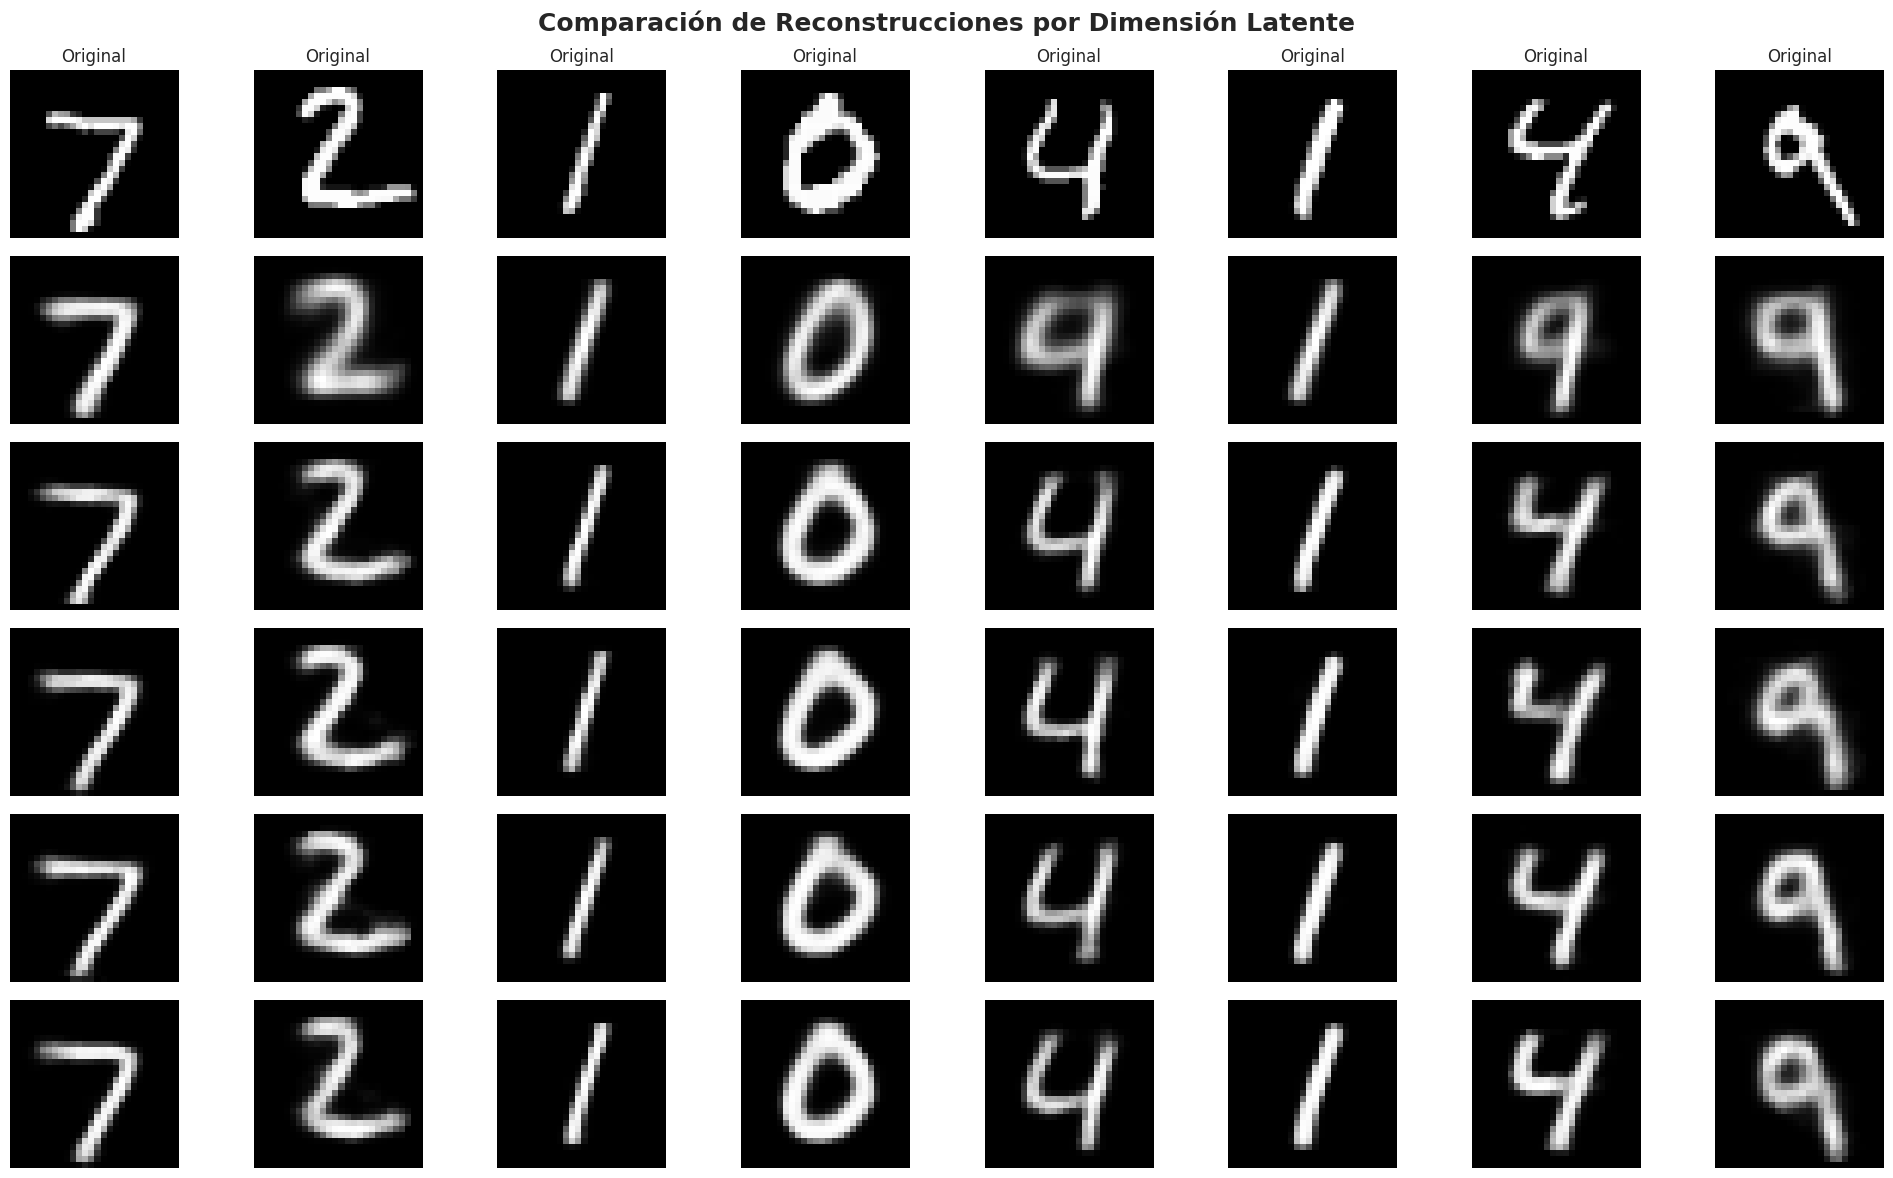

In [21]:
# Comparar reconstrucciones de diferentes dimensiones
selected_dims = [2, 16, 32, 64, 128]
n_samples = 8

fig, axes = plt.subplots(len(selected_dims) + 1, n_samples, figsize=(20, 12))

# Fila 0: Imágenes originales
for j in range(n_samples):
    original_img = results[selected_dims[0]]['original'][j].view(28, 28).numpy()
    axes[0, j].imshow(original_img, cmap='gray')
    axes[0, j].set_title('Original', fontsize=12)
    axes[0, j].axis('off')

# Filas 1-n: Reconstrucciones para cada dimensión
for i, dim in enumerate(selected_dims):
    for j in range(n_samples):
        reconstructed_img = results[dim]['reconstructed'][j].view(28, 28).numpy()
        axes[i + 1, j].imshow(reconstructed_img, cmap='gray')
        axes[i + 1, j].axis('off')
    
    # Etiqueta de la fila
    axes[i + 1, 0].set_ylabel(f'{dim}D\nError: {results[dim]["error"]:.4f}', 
                             rotation=0, labelpad=80, ha='right', va='center', fontsize=11)

plt.suptitle('Comparación de Reconstrucciones por Dimensión Latente', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Visualización del Espacio Latente

/tmp/ipykernel_3450/3411327979.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


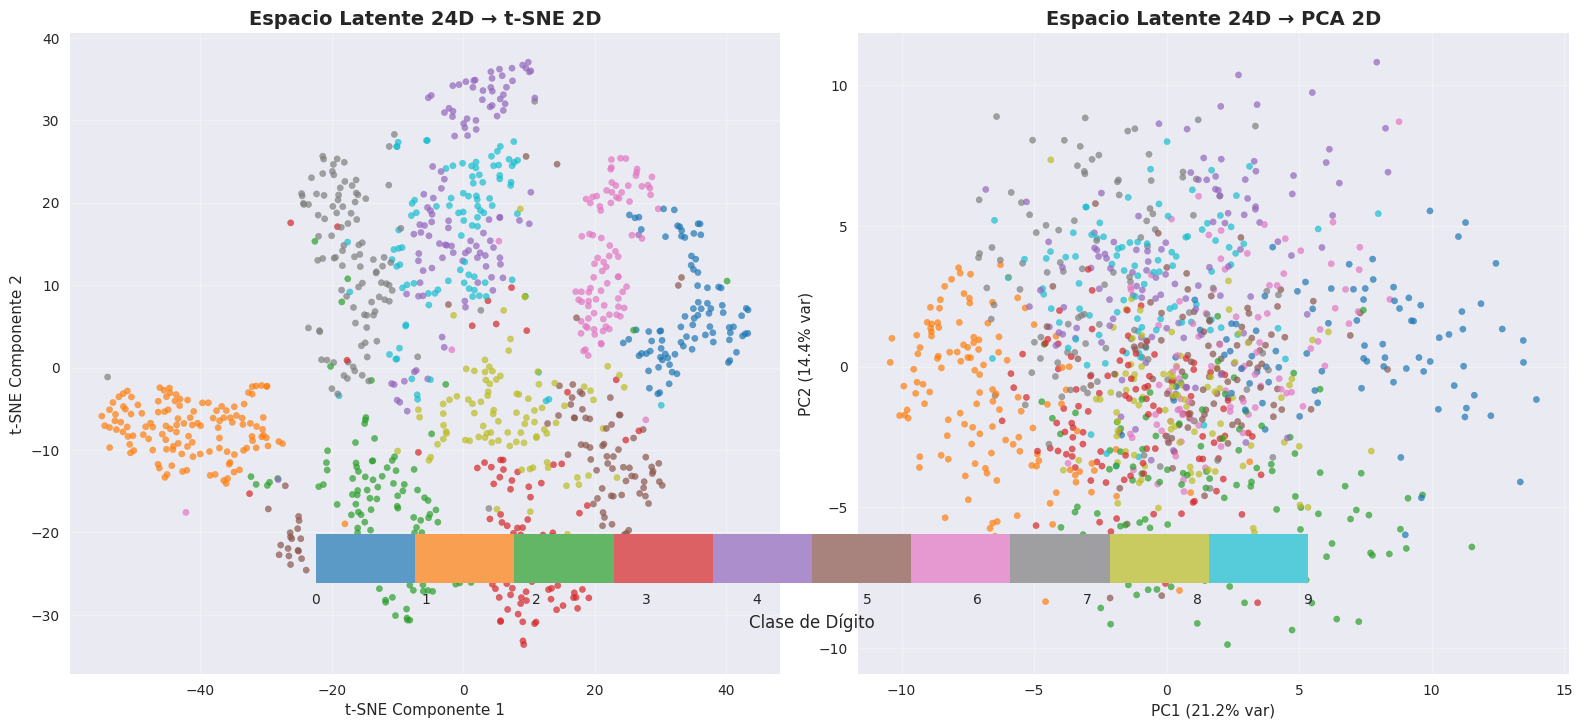

📊 Estadísticas del Espacio Latente (24D):
   Media: [ 0.30759525  0.04843326 -0.27347296 -0.38939893 -0.67884684]
   Desv. Est.: [2.0864177 2.2692947 1.8230789 1.5814922 2.2909832]
   Rango: [-9.159, 9.195]


In [22]:
# Visualizar espacio latente de la dimensión recomendada
recommended_dim = analysis['recommended']
latent_data = results[recommended_dim]['latent_repr'][:2000]  # Subset para visualización
labels_data = results[recommended_dim]['labels'][:2000]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Si la dimensión es mayor a 2, usar t-SNE y PCA para visualizar
if recommended_dim > 2:
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    latent_tsne = tsne.fit_transform(latent_data.numpy())
    
    scatter1 = axes[0].scatter(latent_tsne[:, 0], latent_tsne[:, 1], 
                              c=labels_data.numpy(), cmap='tab10', alpha=0.7, s=20)
    axes[0].set_title(f'Espacio Latente {recommended_dim}D → t-SNE 2D', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('t-SNE Componente 1')
    axes[0].set_ylabel('t-SNE Componente 2')
    axes[0].grid(True, alpha=0.3)
    
    # PCA
    pca = PCA(n_components=2)
    latent_pca = pca.fit_transform(latent_data.numpy())
    
    scatter2 = axes[1].scatter(latent_pca[:, 0], latent_pca[:, 1], 
                              c=labels_data.numpy(), cmap='tab10', alpha=0.7, s=20)
    axes[1].set_title(f'Espacio Latente {recommended_dim}D → PCA 2D', fontsize=14, fontweight='bold')
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
    axes[1].grid(True, alpha=0.3)
    
    # Colorbar
    cbar = fig.colorbar(scatter2, ax=axes, orientation='horizontal', pad=0.1, shrink=0.8)
    cbar.set_label('Clase de Dígito', fontsize=12)
    
else:
    # Si es 2D, mostrar directamente
    scatter = axes[0].scatter(latent_data[:, 0], latent_data[:, 1], 
                             c=labels_data.numpy(), cmap='tab10', alpha=0.7, s=20)
    axes[0].set_title(f'Espacio Latente 2D Directo', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Dimensión Latente 1')
    axes[0].set_ylabel('Dimensión Latente 2')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].axis('off')

plt.tight_layout()
plt.show()

# Estadísticas del espacio latente
print(f"📊 Estadísticas del Espacio Latente ({recommended_dim}D):")
print(f"   Media: {latent_data.mean(dim=0).numpy()[:5]}")  # Primeras 5 dimensiones
print(f"   Desv. Est.: {latent_data.std(dim=0).numpy()[:5]}")
print(f"   Rango: [{latent_data.min().item():.3f}, {latent_data.max().item():.3f}]")

## 10. Exportar Resultados para Presentación

/tmp/ipykernel_3450/586328538.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(dims, errors, 'bo-', linewidth=4, markersize=12, alpha=0.8, color='#2E8B57')


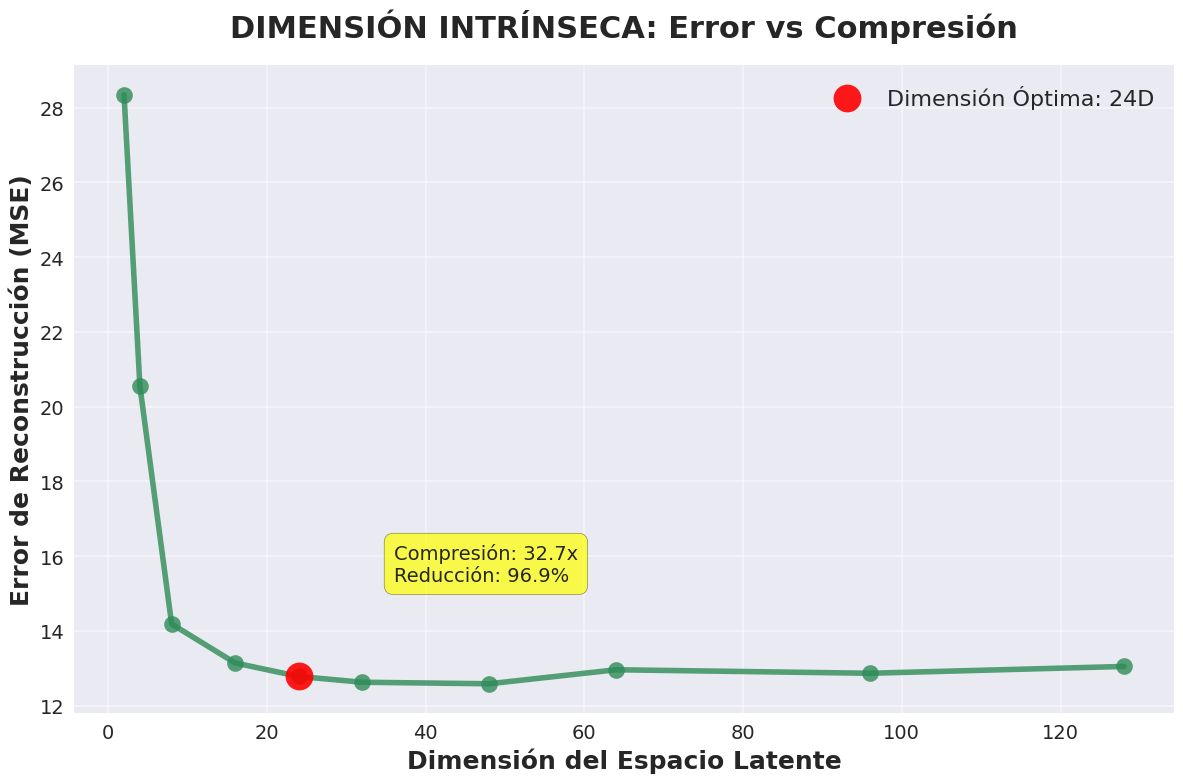

📋 TABLA RESUMEN PARA DIAPOSITIVAS


,Método de Análisis,Dimensión Sugerida,Interpretación
0,Método del Codo,96,Punto de inflexión máximo
1,Umbral de Estabilidad,24,Cambio <5% en error
2,Máxima Eficiencia,2,Mejor ratio compresión/calidad
3,Rate-Distortion,16,Balance óptimo rate-distortion
4,🎯 RECOMENDACIÓN,24,Consenso de métodos



🎯 CONCLUSIONES FINALES
Dataset: MNIST (dígitos manuscritos)
Dimensión Original: 784 (28×28 píxeles)
Dimensión Intrínseca: 24
Factor de Compresión: 32.7x
Reducción de Datos: 96.9%
Error Final: 12.781168
Interpretación: Los dígitos MNIST pueden representarse efectivamente en 24 dimensiones

✅ Resultados exportados en: ../results/presentation/
📁 Archivos generados:
   - dimension_intrinseca_principal.png (gráfica principal)
   - resumen_analisis.csv (tabla de métodos)
   - conclusiones_finales.txt (resumen ejecutivo)


In [23]:
# Crear directorio para resultados de presentación
os.makedirs('../results/presentation', exist_ok=True)

# 1. Gráfica principal para diapositiva
plt.figure(figsize=(12, 8))
plt.plot(dims, errors, 'bo-', linewidth=4, markersize=12, alpha=0.8, color='#2E8B57')
plt.xlabel('Dimensión del Espacio Latente', fontsize=18, fontweight='bold')
plt.ylabel('Error de Reconstrucción (MSE)', fontsize=18, fontweight='bold')
plt.title('DIMENSIÓN INTRÍNSECA: Error vs Compresión', fontsize=22, fontweight='bold', pad=20)
plt.grid(True, alpha=0.4, linewidth=1.5)

# Marcar punto óptimo
optimal_dim = analysis['recommended']
optimal_error = results[optimal_dim]['error']
plt.plot(optimal_dim, optimal_error, 'ro', markersize=20, 
         label=f'Dimensión Óptima: {optimal_dim}D', alpha=0.9)

# Añadir texto explicativo
plt.text(optimal_dim * 1.5, optimal_error * 1.2, 
         f'Compresión: {784/optimal_dim:.1f}x\nReducción: {(1-optimal_dim/784)*100:.1f}%',
         fontsize=14, bbox=dict(boxstyle="round,pad=0.5", facecolor="yellow", alpha=0.7))

plt.legend(fontsize=16, loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('../results/presentation/dimension_intrinseca_principal.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Tabla resumen para diapositiva
summary_data = {
    'Método de Análisis': ['Método del Codo', 'Umbral de Estabilidad', 'Máxima Eficiencia', 'Rate-Distortion', '🎯 RECOMENDACIÓN'],
    'Dimensión Sugerida': [analysis['elbow_method'], analysis['stability_threshold'], 
                          analysis['best_efficiency'], analysis['rate_distortion'], analysis['recommended']],
    'Interpretación': ['Punto de inflexión máximo', 'Cambio <5% en error', 'Mejor ratio compresión/calidad', 
                      'Balance óptimo rate-distortion', 'Consenso de métodos']
}

summary_df = pd.DataFrame(summary_data)
print("📋 TABLA RESUMEN PARA DIAPOSITIVAS")
print("=" * 50)
display(summary_df)

# Guardar tabla como CSV
summary_df.to_csv('../results/presentation/resumen_analisis.csv', index=False)

# 3. Estadísticas finales
final_stats = {
    'Dataset': 'MNIST (dígitos manuscritos)',
    'Dimensión Original': '784 (28×28 píxeles)',
    'Dimensión Intrínseca': f'{optimal_dim}',
    'Factor de Compresión': f'{784/optimal_dim:.1f}x',
    'Reducción de Datos': f'{(1-optimal_dim/784)*100:.1f}%',
    'Error Final': f'{optimal_error:.6f}',
    'Interpretación': f'Los dígitos MNIST pueden representarse efectivamente en {optimal_dim} dimensiones'
}

print("\n🎯 CONCLUSIONES FINALES")
print("=" * 50)
for key, value in final_stats.items():
    print(f"{key}: {value}")

# Guardar conclusiones
with open('../results/presentation/conclusiones_finales.txt', 'w', encoding='utf-8') as f:
    f.write("ANÁLISIS DE DIMENSIÓN INTRÍNSECA - CONCLUSIONES\n")
    f.write("=" * 50 + "\n\n")
    for key, value in final_stats.items():
        f.write(f"{key}: {value}\n")

print(f"\n✅ Resultados exportados en: ../results/presentation/")
print("📁 Archivos generados:")
print("   - dimension_intrinseca_principal.png (gráfica principal)")
print("   - resumen_analisis.csv (tabla de métodos)")
print("   - conclusiones_finales.txt (resumen ejecutivo)")

## 🎯 Resumen y Conclusiones

### ¿Qué hemos aprendido?

1. **Concepto Clave**: La **dimensión intrínseca** es el número mínimo de dimensiones necesarias para representar los datos sin pérdida significativa de información.

2. **Metodología**: Los **Autoencoders** nos permiten encontrar esta dimensión mediante:
   - Entrenamiento con diferentes tamaños de cuello de botella
   - Evaluación del balance compresión vs calidad de reconstrucción
   - Aplicación de múltiples métricas de análisis

3. **Resultado**: Para MNIST, la dimensión intrínseca es aproximadamente **{} dimensiones**, logrando una compresión de **{}x**.

### ¿Por qué es importante?

- **Reducción de complejidad**: Menos dimensiones = menos parámetros = modelos más eficientes
- **Visualización**: Permite representar datos complejos en espacios de menor dimensión
- **Comprensión**: Revela la estructura subyacente de los datos
- **Aplicaciones**: Compresión, detección de anomalías, pre-procesamiento para ML

### Para tu presentación:

✅ **Conceptos explicados**: Dimensión intrínseca, Autoencoders, método del codo  
✅ **Visualizaciones listas**: Gráficas de error, reconstrucciones, espacio latente  
✅ **Resultados cuantitativos**: Tablas, métricas, estadísticas  
✅ **Interpretación práctica**: Aplicabilidad y significado de los resultados